In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

from ydata_profiling import ProfileReport
import webbrowser


/var/folders/gc/n9f0hqw521d0_z3nmf82zyrc0000gn/T/ipykernel_3735/3033676398.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'ydata_profiling'

In [ ]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

In [ ]:
insurance.shape

In [ ]:
insurance.describe()

In [ ]:
ydata_report = ProfileReport(insurance, title='insurance_data', explorative=True)

# Save the report as an HTML file
ydata_report.to_file("insurance_report.html")

webbrowser.open('insurance_report.html')

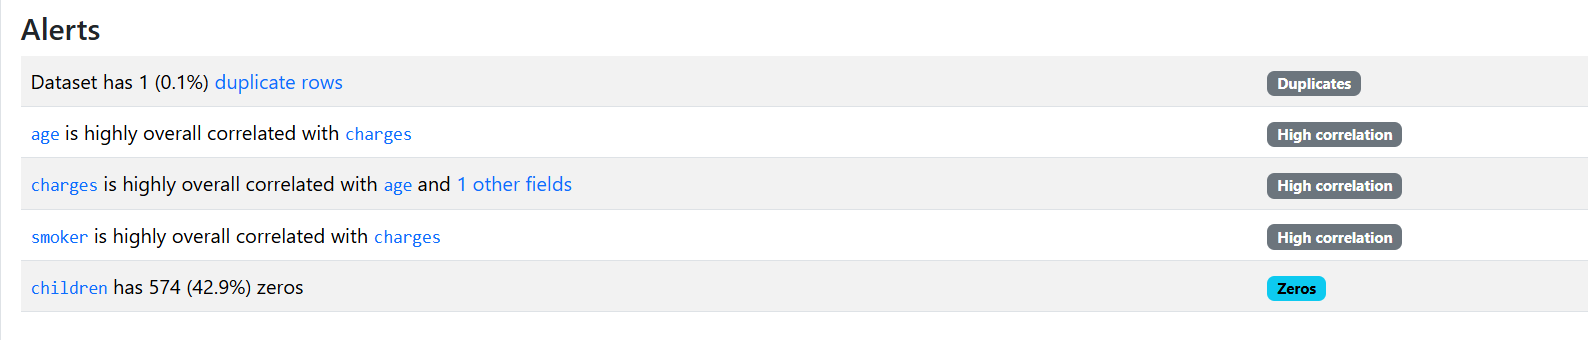

In [ ]:
# remove duplicates
insurance = insurance.drop_duplicates()

In [ ]:
# Check duplicates
insurance.duplicated().sum()

Charges are highly correlated with Age and Smoker which is undestamdable

In [ ]:
# Check zeros
insurance.isin([0]).sum()

In [ ]:
# zeros doesnt remove
insurance = insurance[insurance['children'] != 0]

In [ ]:
# Check zeros
insurance.isin([0]).sum()

In [ ]:
insurance.shape

In [ ]:
# Convert all categorical variables to numeric
# sex has male female
# smoker has yes no
# region has northeast, southeast, southwest, northwest

insurance['sex'] = insurance['sex'].map({'female': 0, 'male': 1})
insurance['smoker'] = insurance['smoker'].map({'no': 0, 'yes': 1})

# One-Hot Encoding for 'region'
insurance = pd.get_dummies(insurance, columns=['region'], drop_first=True, dtype='int')
insurance.head()

In [ ]:
# As i have lesser data will do synthetic data generation using CTGAN
from imblearn.under_sampling import RandomUnderSampler
from ctgan import CTGAN

target = 'charges'
X = insurance.drop(columns=[target])
y = insurance[target]

ctgan = CTGAN()
ctgan.fit(insurance, epochs=100)

# Generate synthetic data
synthetic_data = ctgan.sample(1000)


In [ ]:
synthetic_data.head()

In [ ]:
synthetic_data.shape

In [ ]:
# combine original and synthetic data
combined_data = pd.concat([insurance, synthetic_data], ignore_index=True)

# Reset index
combined_data.reset_index(drop=True, inplace=True)
combined_data.shape 

In [ ]:
# rename the df as insurance_final
insurance_final = combined_data

VARIATION...............

In [ ]:
insurance_final.var()

SDV-------------------------Data synthetization

In [ ]:
# See the target variable distribution before and after
sns.histplot(data=insurance_final, x="charges", kde=True)

In [ ]:
# pip install sdv
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata

# Create metadata from the DataFrame
metadata = Metadata.detect_from_dataframes(
    data={'insurance_final': insurance_final}
)

# initialize the Gaussian Copula Model
model = GaussianCopulaSynthesizer(metadata)

# fit the model
model.fit(insurance_final)

# use the model to generate 1000 new data rows
synthetic_data2 = model.sample(num_rows=1000)

synthetic_data2.shape

In [ ]:
# Combine the original data with the new synthetic data
df = pd.concat([insurance_final, synthetic_data2])
df.shape

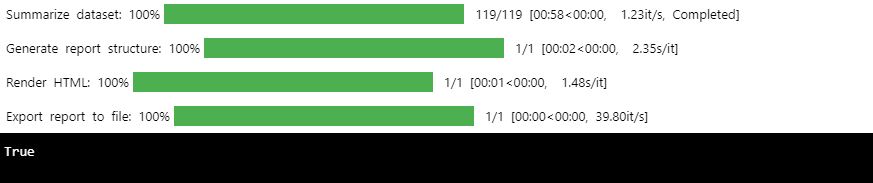

In [ ]:
# See the target variable distribution before and after
sns.histplot(data=df, x="charges", kde=True)

RANSAC-------------------------Noise management

In [ ]:
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_sdv = df.copy()

In [ ]:
X = df_sdv.drop("charges", axis=1)
y = df_sdv['charges']

# Fit a RANSAC regressor to identify outliers
ransac = RANSACRegressor(residual_threshold=np.std(y) * 2)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outliers = df_sdv[~inlier_mask]
inliers = df_sdv[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

SAVE INLIERS AND USE IT

In [ ]:
inliers.to_csv('inliers.csv', index=False)

inliers_data = pd.read_csv('inliers.csv')
inliers_data

ANOMALY -------------------------Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1, random_state=222) # 0.1 means 10% of the data will be considered as outliers

yhat = iso.fit_predict(inliers_data)

# Filter outliers
amomaly = inliers_data[yhat != 1]

# remove the outliers
df_new = inliers_data.drop(outliers.index)
df_new


In [ ]:
# Remove zeros from the data
df_new = df_new[(df_new.T != 0).any()]

# remove duplicates
df_new = df_new.drop_duplicates()

# Remove NaN values
df_new = df_new.dropna()

# Reset index
df_new.reset_index(drop=True, inplace=True)

# Remove duplicates again after cleaning
df_new = df_new.drop_duplicates()
# Save the cleaned data
df_new.to_csv('cleaned_insurance_data.csv', index=False)

#Load the cleaned data
cleaned_data = pd.read_csv('cleaned_insurance_data.csv')
cleaned_data.describe()



In [ ]:
ydata_report = ProfileReport(cleaned_data, title='cleaned_data', explorative=True)

# Save the report as an HTML file
ydata_report.to_file("cleaned_data.html")

webbrowser.open('cleaned_data.html')

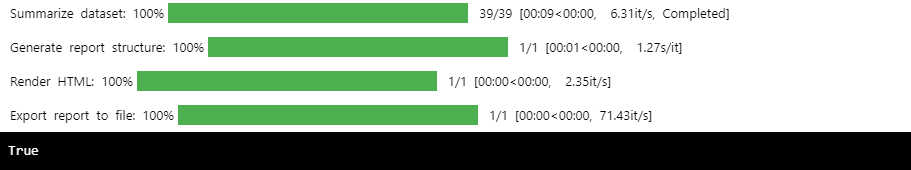

In [ ]:
cleaned_data.var()

In [ ]:
# Create the heatmap for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(cleaned_data.isnull(), cbar=False, cmap='viridis')

# Add title and labels
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Save the heatmap as an image (optional)
plt.savefig('missing_values_heatmap.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

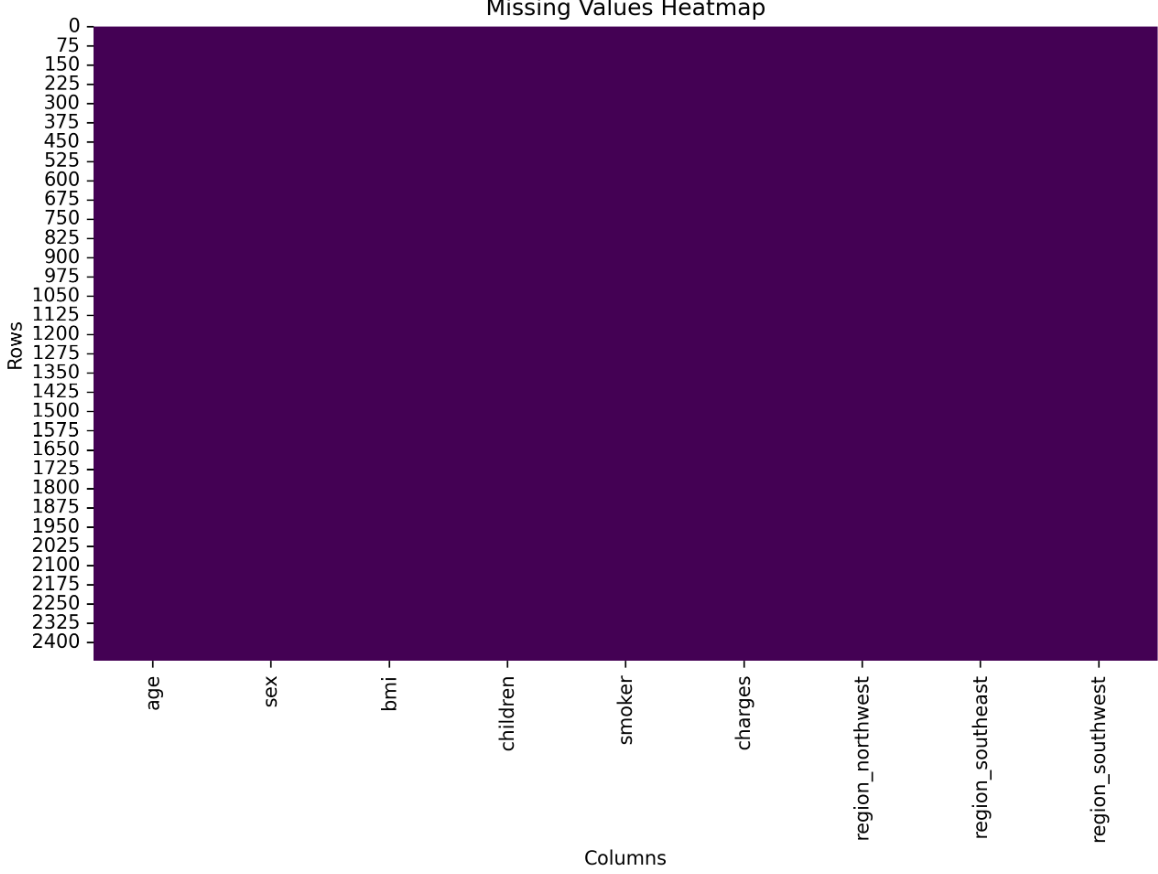

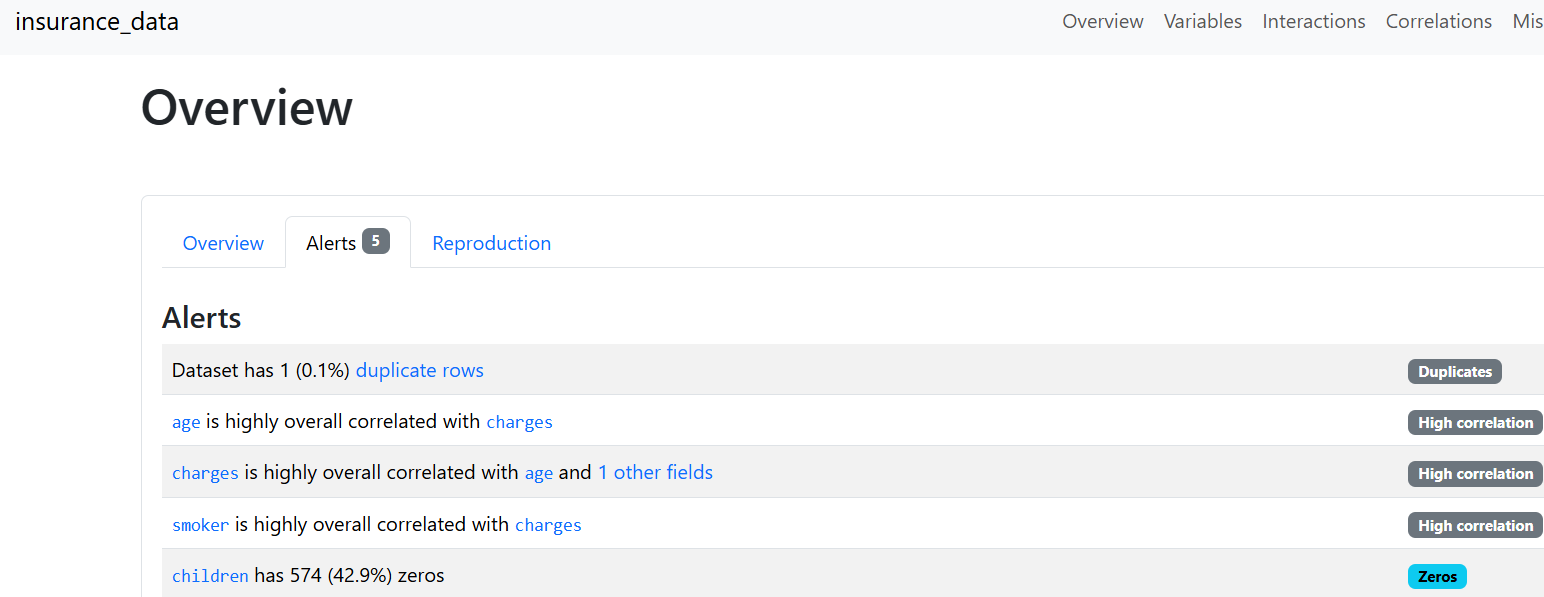

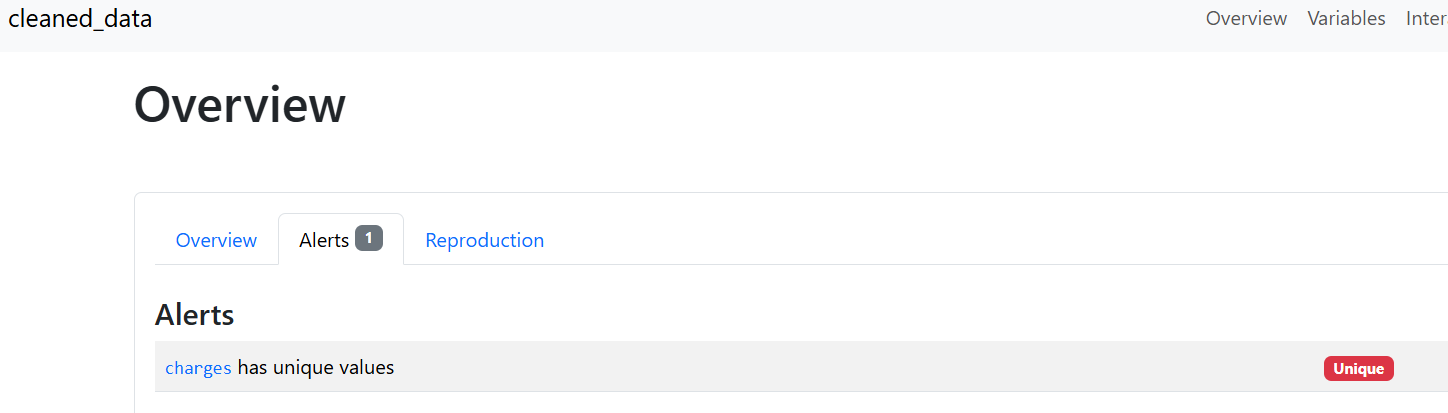

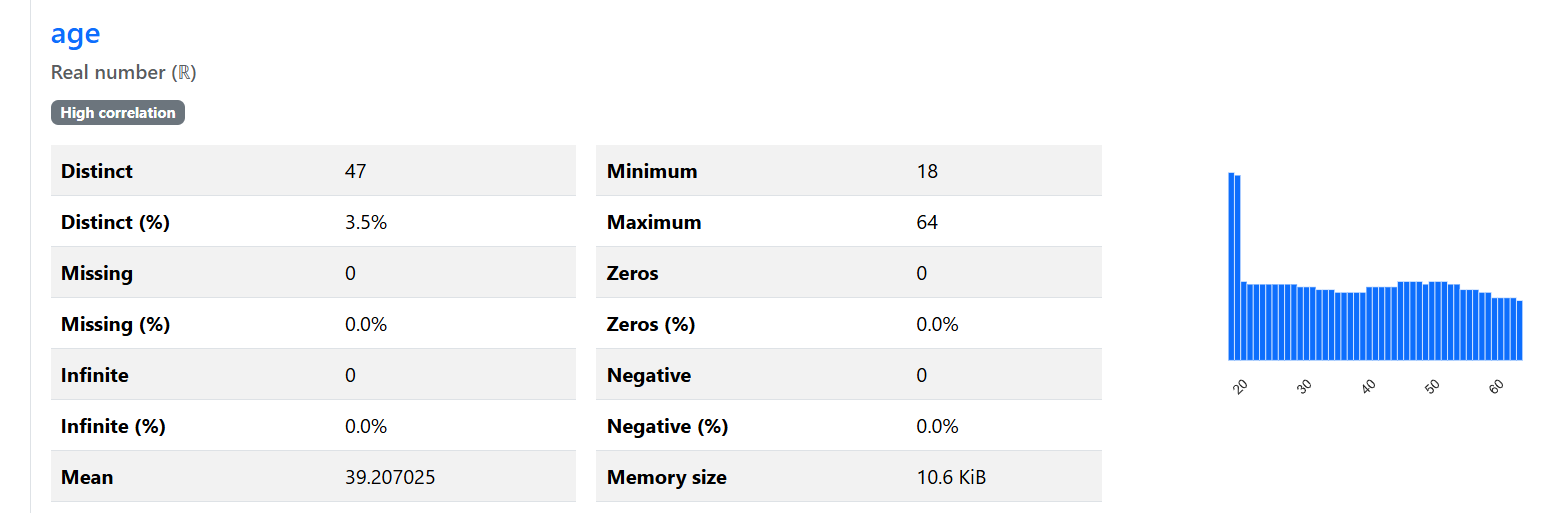

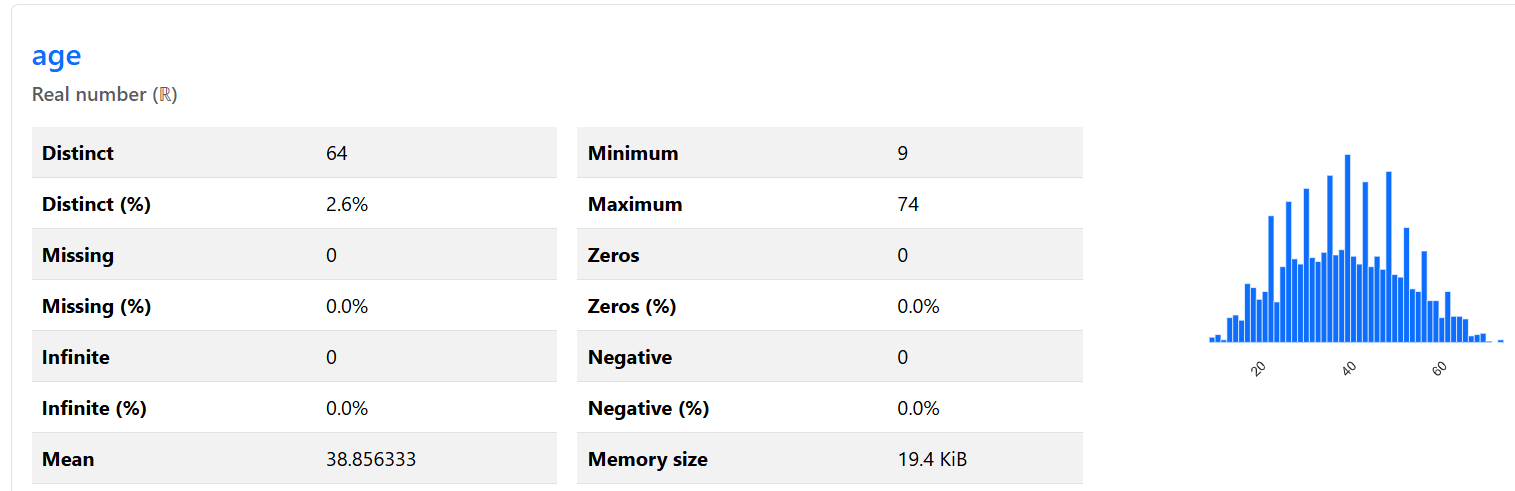

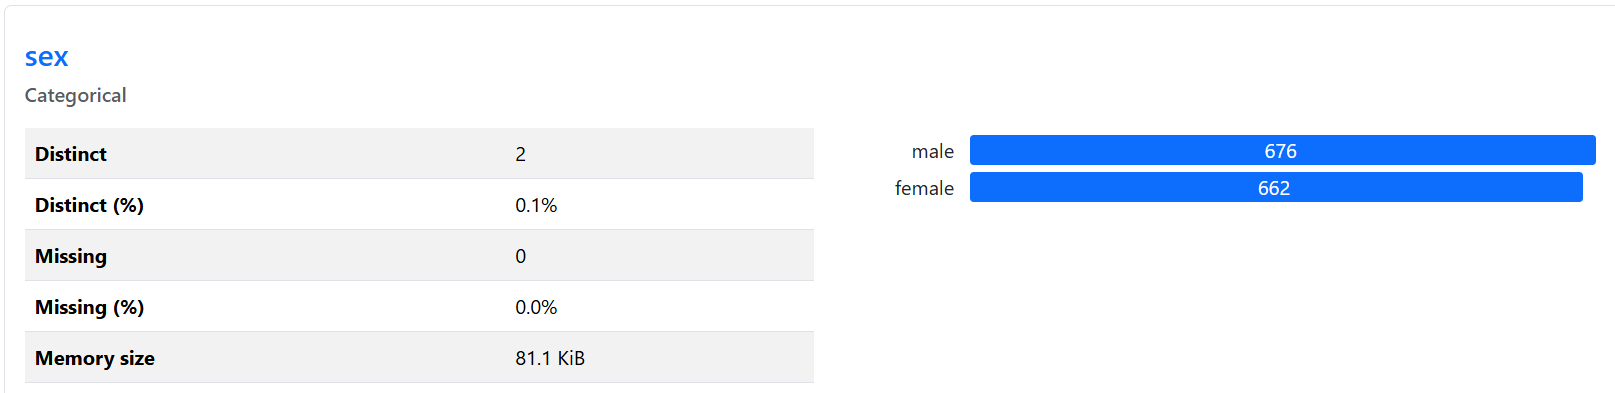

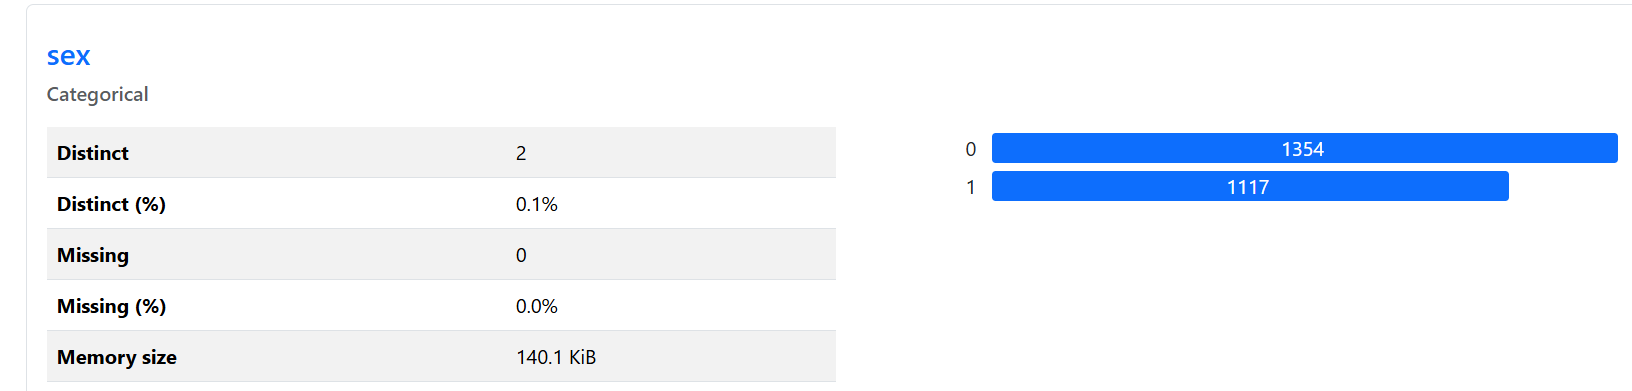

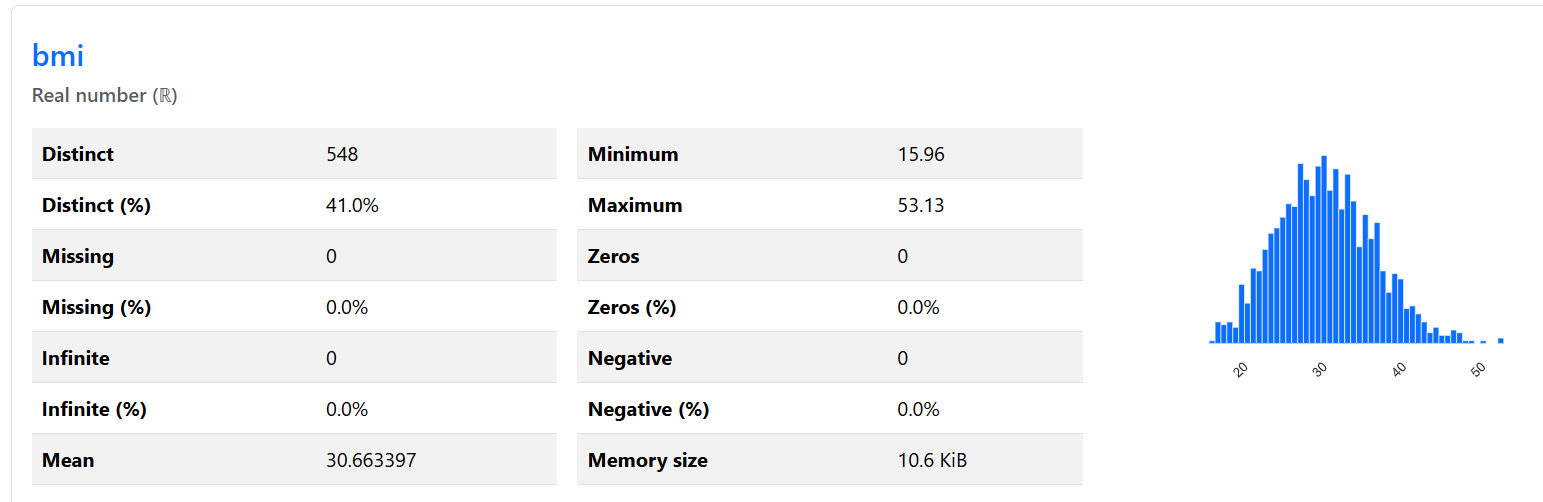

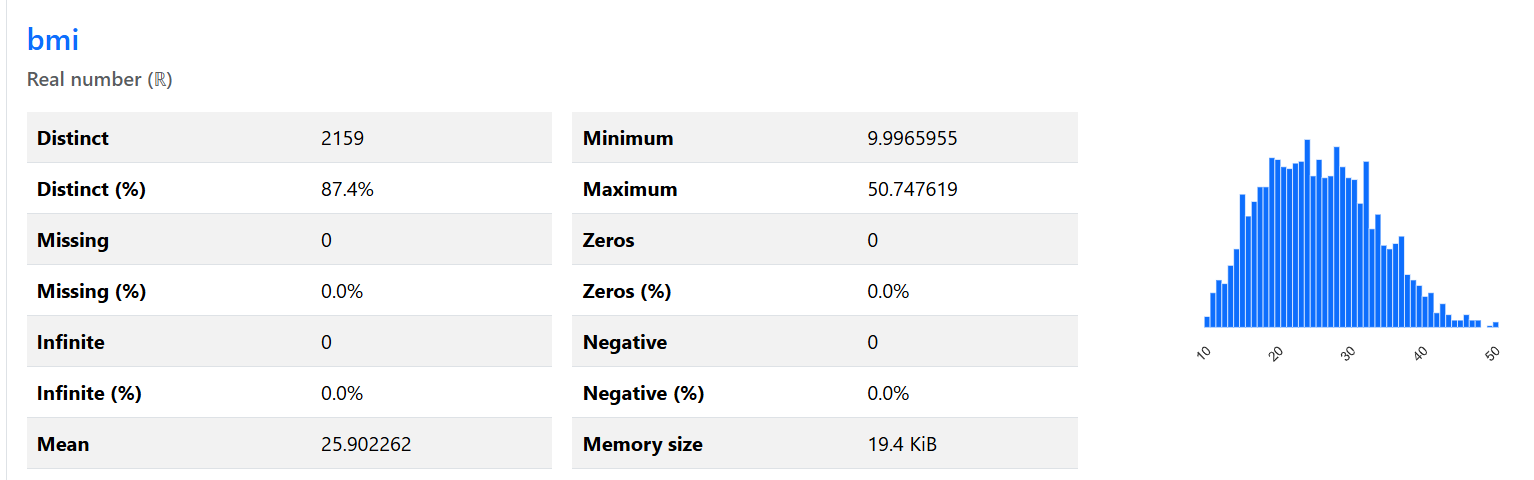

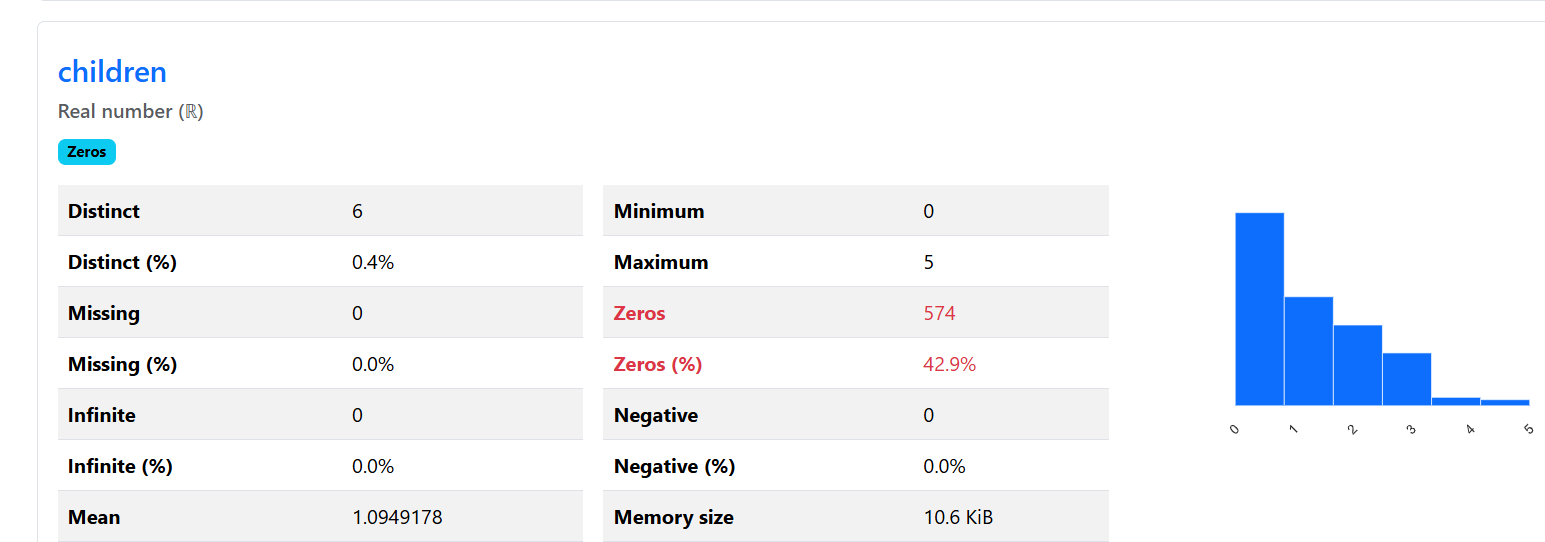

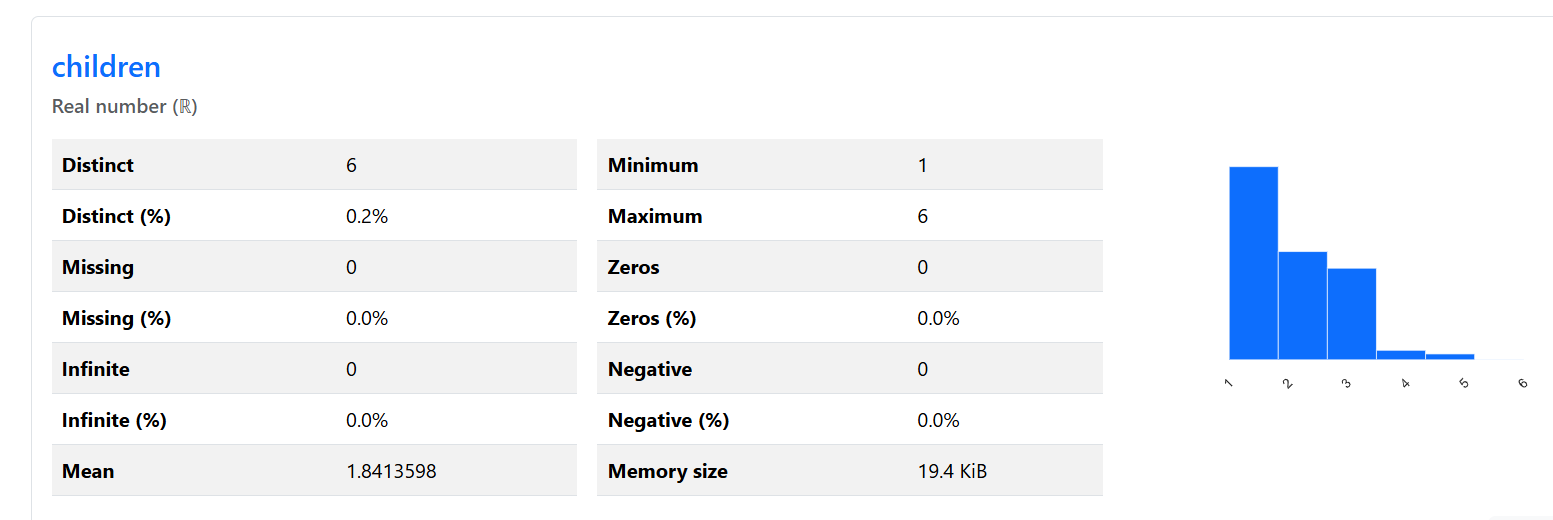

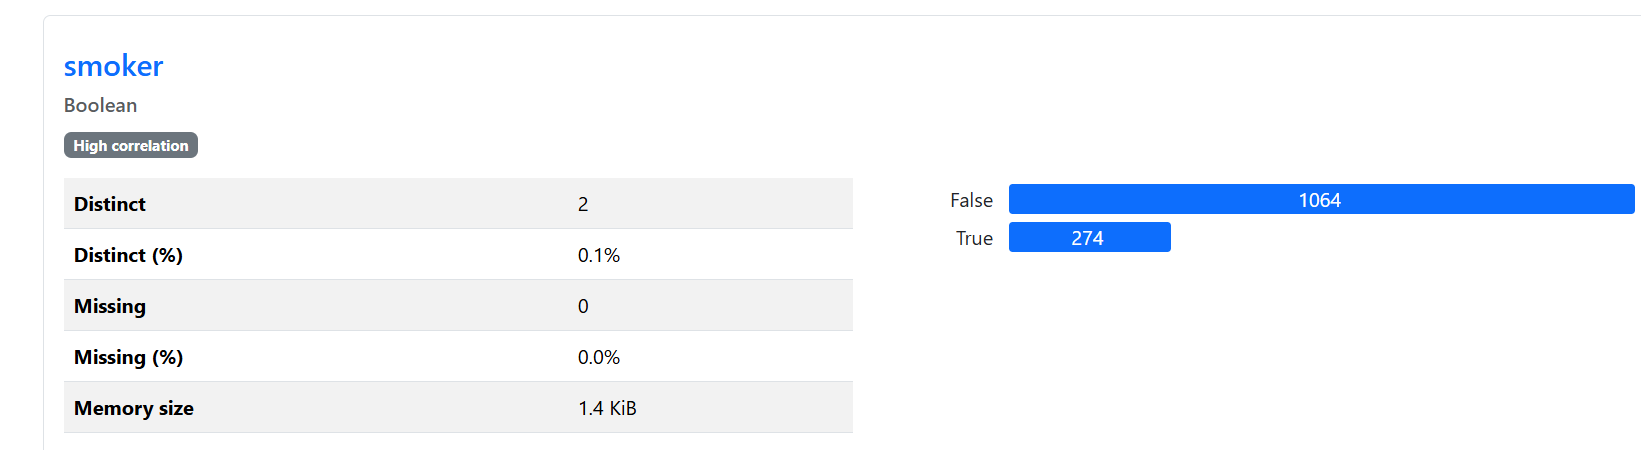

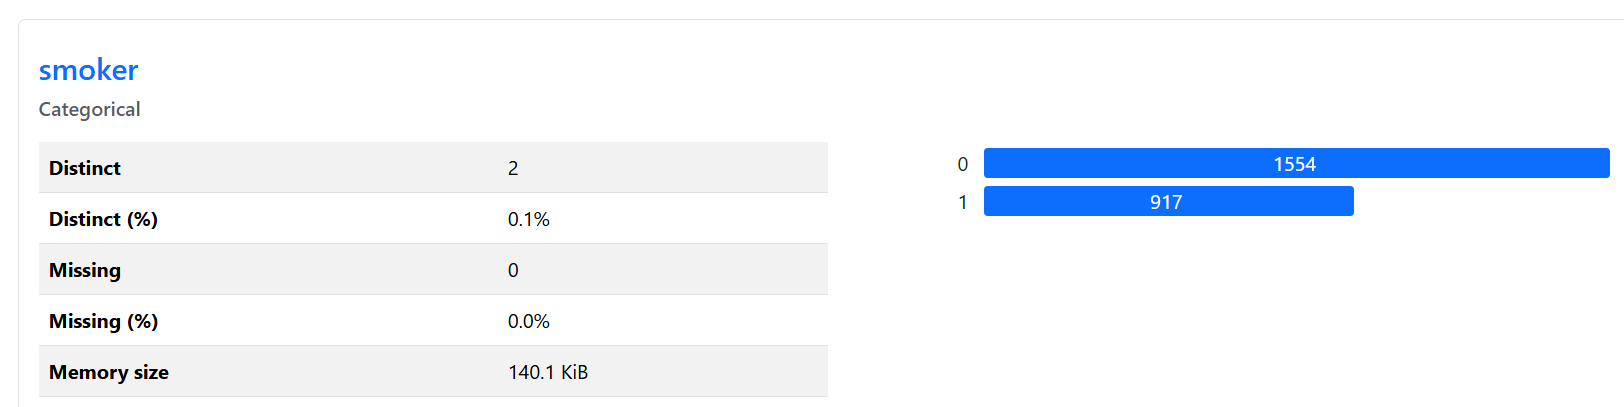

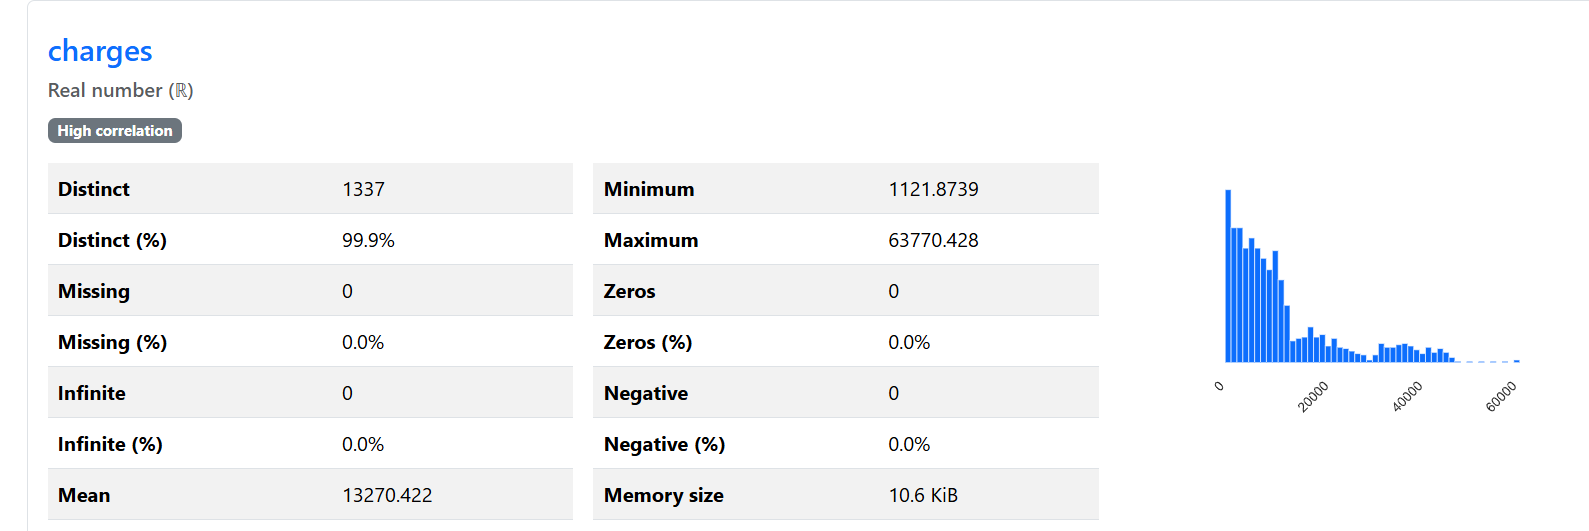

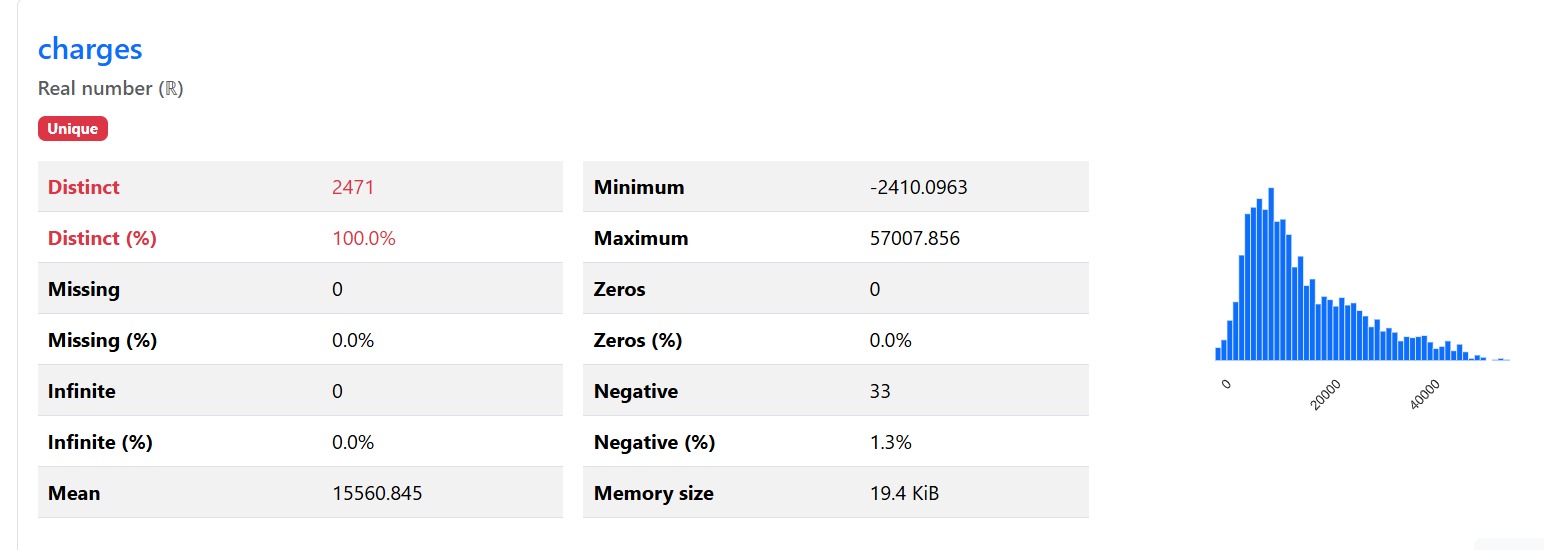